In [3]:
import findspark
findspark.init()

In [22]:
from pyspark.sql import SparkSession

In [4]:
import sys
sys.path.append('src/')

import util

In [7]:
# create a Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify_modelling_v2") \
        .getOrCreate()

In [8]:
user_dataset = "spark_user_data.csv"

df = spark.read.csv(user_dataset, header=True, inferSchema=True)

In [9]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- num_songs: integer (nullable = true)
 |-- num_songs_unique: integer (nullable = true)
 |-- num_artist: integer (nullable = true)
 |-- total_play_length: double (nullable = true)
 |-- num_active_days: integer (nullable = true)
 |-- date_from: string (nullable = true)
 |-- date_to: string (nullable = true)
 |-- registration_date: string (nullable = true)
 |-- num_active_days_paid: double (nullable = true)
 |-- About: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- Cancel: double (nullable = true)
 |-- Cancellation Confirmation: double (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Home: double (nullable = true)
 |-- Login: double (nullable = true)
 |-- Logout: double (nullable = true)
 |-- NextSong: integer (nullable = true)
 |-- Register: double (nullable = true)
 |-- Roll Advert:

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### These classifiers are considered.

- Logistic Regression
- Decision Tree
- K-Nearest Neighbors

In [63]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler

In [153]:
feature_cols = \
['num_songs',
 'num_artist',
 'num_active_days',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Thumbs Up',
 'days_since_registration',
 'avg_songs_per_active_day',
 'avg_play_length_per_active_day']

In [156]:
numeric_data.head()

,num_songs,num_artist,num_active_days,Add Friend,Add to Playlist,Downgrade,Thumbs Up,days_since_registration,avg_songs_per_active_day,avg_play_length_per_active_day
0,1022,767,23,14.0,25.0,3.0,53.0,78,44.434783,11276.082490
1,1778,1205,22,25.0,49.0,14.0,92.0,67,80.818182,20143.072811
2,250,223,4,13.0,5.0,5.0,7.0,55,62.500000,15817.754540
3,1472,1071,13,23.0,46.0,15.0,66.0,133,113.230769,28022.066344
4,236,215,4,4.0,7.0,1.0,10.0,117,59.000000,14754.944690


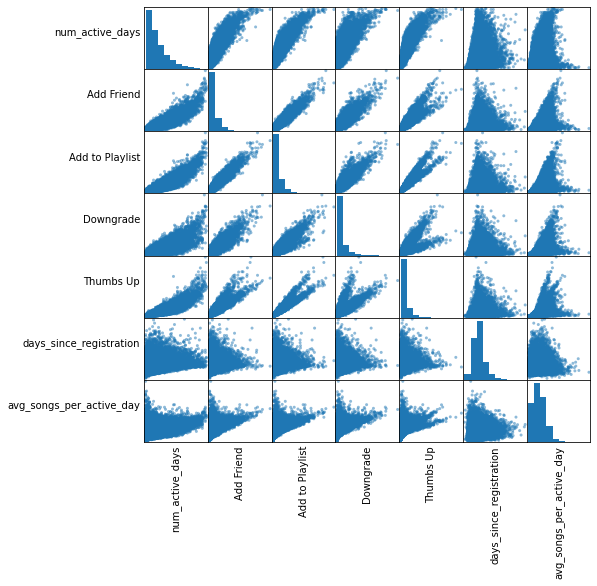

In [161]:
import pandas as pd
from pandas.plotting import scatter_matrix

numeric_data = df.select(feature_cols).toPandas()

axs = scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [160]:
feature_cols = \
['num_active_days',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Thumbs Up',
 'days_since_registration',
 'avg_songs_per_active_day']

In [111]:
vectorAssembler = VectorAssembler(inputCols = feature_cols, outputCol = 'features')

In [112]:
v_df = vectorAssembler.transform(df)

In [113]:
v_df.head()

Row(userId=1000280, num_songs=1022, num_songs_unique=945, num_artist=767, total_play_length=259349.89725999985, num_active_days=23, date_from='2018-08-29', date_to='2018-11-14', registration_date='2018-08-29', num_active_days_paid=2.0, About=0.0, Add Friend=14.0, Add to Playlist=25.0, Cancel=1.0, Cancellation Confirmation=1.0, Downgrade=3.0, Error=3.0, Help=8.0, Home=44.0, Login=0.0, Logout=15.0, NextSong=1022, Register=0.0, Roll Advert=74.0, Save Settings=1.0, Settings=9.0, Submit Downgrade=1.0, Submit Registration=0.0, Submit Upgrade=1.0, Thumbs Down=33.0, Thumbs Up=53.0, Upgrade=9.0, current_level='free', current_level_paid=0, days_since_registration=78, days_in_member=78, active_pct=0.2948717948717949, avg_songs_per_day=13.102564102564102, avg_songs_per_active_day=44.43478260869565, avg_play_length_per_day=3324.998682820511, avg_play_length_per_active_day=11276.082489565211, churn=1, features=DenseVector([23.0, 14.0, 25.0, 3.0, 53.0, 78.0, 44.4348]))

In [114]:
scaler = Normalizer(inputCol="features", outputCol="ScaledFeatures")
v_df = scaler.transform(v_df)

In [115]:
v_df.select(col('ScaledFeatures')).head(20)

[Row(ScaledFeatures=DenseVector([0.208, 0.1266, 0.2261, 0.0271, 0.4793, 0.7054, 0.4019])),
 Row(ScaledFeatures=DenseVector([0.1445, 0.1642, 0.3218, 0.0919, 0.6041, 0.44, 0.5307])),
 Row(ScaledFeatures=DenseVector([0.0471, 0.153, 0.0589, 0.0589, 0.0824, 0.6475, 0.7358])),
 Row(ScaledFeatures=DenseVector([0.0668, 0.1181, 0.2363, 0.077, 0.339, 0.6831, 0.5816])),
 Row(ScaledFeatures=DenseVector([0.0304, 0.0304, 0.0531, 0.0076, 0.0759, 0.8882, 0.4479])),
 Row(ScaledFeatures=DenseVector([0.1481, 0.2617, 0.4648, 0.1136, 0.6886, 0.334, 0.308])),
 Row(ScaledFeatures=DenseVector([0.0438, 0.0625, 0.1, 0.0188, 0.1813, 0.8377, 0.4992])),
 Row(ScaledFeatures=DenseVector([0.103, 0.0515, 0.0809, 0.0074, 0.1912, 0.9415, 0.2391])),
 Row(ScaledFeatures=DenseVector([0.1636, 0.2415, 0.2026, 0.1402, 0.5765, 0.4986, 0.5227])),
 Row(ScaledFeatures=DenseVector([0.0877, 0.0, 0.0292, 0.0, 0.1169, 0.8765, 0.4577])),
 Row(ScaledFeatures=DenseVector([0.1218, 0.1377, 0.2278, 0.0901, 0.3973, 0.7947, 0.3418])),
 Row(S

In [116]:
scaler2 = StandardScaler(inputCol="ScaledFeatures", outputCol="ScaledFeatures2", withStd=True)
scalerModel = scaler2.fit(v_df)
v_df = scalerModel.transform(v_df)

In [117]:
v_df.select(col('ScaledFeatures'), col('ScaledFeatures2')).head(20)

[Row(ScaledFeatures=DenseVector([0.208, 0.1266, 0.2261, 0.0271, 0.4793, 0.7054, 0.4019]), ScaledFeatures2=DenseVector([3.894, 1.557, 1.9004, 0.5404, 2.132, 3.0072, 1.9933])),
 Row(ScaledFeatures=DenseVector([0.1445, 0.1642, 0.3218, 0.0919, 0.6041, 0.44, 0.5307]), ScaledFeatures2=DenseVector([2.7045, 2.0188, 2.7046, 1.8312, 2.6871, 1.8756, 2.6324])),
 Row(ScaledFeatures=DenseVector([0.0471, 0.153, 0.0589, 0.0589, 0.0824, 0.6475, 0.7358]), ScaledFeatures2=DenseVector([0.8816, 1.882, 0.4948, 1.1725, 0.3665, 2.7603, 3.6497])),
 Row(ScaledFeatures=DenseVector([0.0668, 0.1181, 0.2363, 0.077, 0.339, 0.6831, 0.5816]), ScaledFeatures2=DenseVector([1.25, 1.4527, 1.986, 1.5346, 1.5078, 2.9122, 2.8848])),
 Row(ScaledFeatures=DenseVector([0.0304, 0.0304, 0.0531, 0.0076, 0.0759, 0.8882, 0.4479]), ScaledFeatures2=DenseVector([0.5685, 0.3734, 0.4467, 0.1512, 0.3377, 3.7864, 2.2217])),
 Row(ScaledFeatures=DenseVector([0.1481, 0.2617, 0.4648, 0.1136, 0.6886, 0.334, 0.308]), ScaledFeatures2=DenseVector([

In [118]:
v_df = v_df.select(v_df.churn, v_df.ScaledFeatures2) \
        .withColumn('label', v_df.churn) \
        .withColumn('features', v_df.ScaledFeatures2)

splits = v_df.randomSplit([0.8, 0.2], seed=42)
train_df = splits[0]
test_df  = splits[1]

In [119]:
v_df.head()

Row(churn=1, ScaledFeatures2=DenseVector([3.894, 1.557, 1.9004, 0.5404, 2.132, 3.0072, 1.9933]), label=1, features=DenseVector([3.894, 1.557, 1.9004, 0.5404, 2.132, 3.0072, 1.9933]))

In [122]:
# lr = LogisticRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr = LogisticRegression(featuresCol = 'features', labelCol='label')
lrmodel = lr.fit(train_df)

print("Coefficients: " + str(lrmodel.coefficients))
print("Intercept: " + str(lrmodel.intercept))

Coefficients: [0.41447991228529485,-0.05133494164780514,-0.12829546579950554,0.36983672937825024,-1.1006264884670682,-0.9645051224316084,0.20490105615569434]
Intercept: 1.5561679152595738


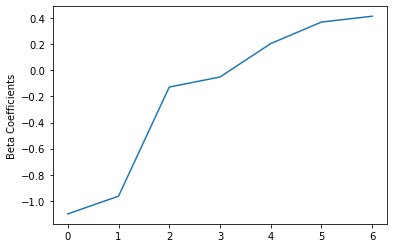

In [123]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrmodel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

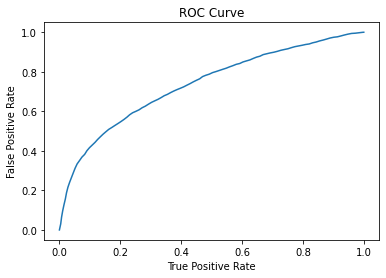

Training set areaUnderROC: 0.7351911960075196


In [124]:
trainingSummary = lrmodel.summary

roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

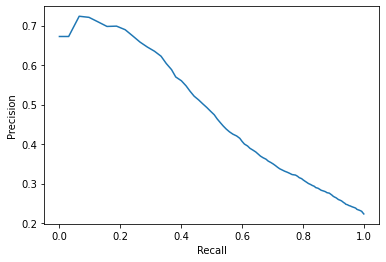

In [125]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [130]:
predictions = lrmodel.transform(test_df)
predictions.head(5)
# predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

[Row(churn=0, ScaledFeatures2=SparseVector(7, {0: 0.1052, 5: 4.2623, 6: 0.0836}), label=0, features=SparseVector(7, {0: 0.1052, 5: 4.2623, 6: 0.0836}), rawPrediction=DenseVector([2.4942, -2.4942]), probability=DenseVector([0.9237, 0.0763]), prediction=0.0),
 Row(churn=0, ScaledFeatures2=SparseVector(7, {0: 0.1614, 5: 4.2627, 6: 0.0428}), label=0, features=SparseVector(7, {0: 0.1614, 5: 4.2627, 6: 0.0428}), rawPrediction=DenseVector([2.4796, -2.4796]), probability=DenseVector([0.9227, 0.0773]), prediction=0.0),
 Row(churn=0, ScaledFeatures2=SparseVector(7, {0: 0.1662, 5: 4.2386, 6: 0.5284}), label=0, features=SparseVector(7, {0: 0.1662, 5: 4.2386, 6: 0.5284}), rawPrediction=DenseVector([2.3548, -2.3548]), probability=DenseVector([0.9133, 0.0867]), prediction=0.0),
 Row(churn=0, ScaledFeatures2=SparseVector(7, {0: 0.1733, 5: 4.2216, 6: 0.6886}), label=0, features=SparseVector(7, {0: 0.1733, 5: 4.2216, 6: 0.6886}), rawPrediction=DenseVector([2.3026, -2.3026]), probability=DenseVector([0.9

In [131]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()

print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7407260800231313


In [140]:
from pyspark.ml.classification import DecisionTreeClassifier


dt = DecisionTreeClassifier(featuresCol = 'features', labelCol='label', maxDepth=2)
dt_model = dt.fit(train_df)

predictions_dt = dt_model.transform(test_df)
predictions_dt.select('rawPrediction', 'prediction', 'probability').show(10)

+----------------+----------+--------------------+
|   rawPrediction|prediction|         probability|
+----------------+----------+--------------------+
|[12088.0,2446.0]|       0.0|[0.83170496766203...|
|[12088.0,2446.0]|       0.0|[0.83170496766203...|
|[12088.0,2446.0]|       0.0|[0.83170496766203...|
|[12088.0,2446.0]|       0.0|[0.83170496766203...|
|[12088.0,2446.0]|       0.0|[0.83170496766203...|
|[12088.0,2446.0]|       0.0|[0.83170496766203...|
|[12088.0,2446.0]|       0.0|[0.83170496766203...|
|[12088.0,2446.0]|       0.0|[0.83170496766203...|
|[12088.0,2446.0]|       0.0|[0.83170496766203...|
|[12088.0,2446.0]|       0.0|[0.83170496766203...|
+----------------+----------+--------------------+
only showing top 10 rows



In [141]:
evaluator_dt = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator_dt.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.3621734325152653


In [142]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_model = rf.fit(train_df)
predictions_rf = rf_model.transform(test_df)
predictions_rf.select('rawPrediction', 'prediction', 'probability').show(10)

+--------------------+----------+--------------------+
|       rawPrediction|prediction|         probability|
+--------------------+----------+--------------------+
|[17.2328976135083...|       0.0|[0.86164488067541...|
|[17.2328976135083...|       0.0|[0.86164488067541...|
|[17.2328976135083...|       0.0|[0.86164488067541...|
|[17.2328976135083...|       0.0|[0.86164488067541...|
|[17.2328976135083...|       0.0|[0.86164488067541...|
|[17.2328976135083...|       0.0|[0.86164488067541...|
|[17.2328976135083...|       0.0|[0.86164488067541...|
|[17.2328976135083...|       0.0|[0.86164488067541...|
|[17.2328976135083...|       0.0|[0.86164488067541...|
|[17.2328976135083...|       0.0|[0.86164488067541...|
+--------------------+----------+--------------------+
only showing top 10 rows



In [143]:
evaluator_rf = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator_rf.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.741148773188247


In [145]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbt_model = gbt.fit(train_df)
predictions_gbt = gbt_model.transform(test_df)
predictions_gbt.select('rawPrediction', 'prediction', 'probability').show(10)

+--------------------+----------+--------------------+
|       rawPrediction|prediction|         probability|
+--------------------+----------+--------------------+
|[0.82030338369523...|       0.0|[0.83761748345047...|
|[0.82030338369523...|       0.0|[0.83761748345047...|
|[0.82030338369523...|       0.0|[0.83761748345047...|
|[0.82030338369523...|       0.0|[0.83761748345047...|
|[0.82030338369523...|       0.0|[0.83761748345047...|
|[0.82030338369523...|       0.0|[0.83761748345047...|
|[0.82030338369523...|       0.0|[0.83761748345047...|
|[0.82030338369523...|       0.0|[0.83761748345047...|
|[0.82030338369523...|       0.0|[0.83761748345047...|
|[0.82030338369523...|       0.0|[0.83761748345047...|
+--------------------+----------+--------------------+
only showing top 10 rows



In [146]:
evaluator_gbt = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator_gbt.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7407260800231313


In [148]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [147]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cv_model = cv.fit(train_df)
predictions_cv = cv_model.transform(test_df)
evaluator.evaluate(predictions_cv)

0.7608940018504438